# Notebook for experiments regarding Research Question #2

**Research Question 2**:  How does the output decoder relate to the input
embedding, does it simply invert the input embedding or predict
the next word?

## Load Model

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, AutoConfig, StoppingCriteriaList, StoppingCriteria
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from datasets import load_dataset

import collections
import itertools
import torch
import scipy
import csv
import gc
import os

In [2]:
#model_id = "mistralai/Mistral-7B-v0.1"
model_id = "meta-llama/Llama-2-7b-hf"
#model_id = "microsoft/phi-1_5"
#model_name = "Mistral"
model_name = "LLama2"
#model_name = "Phi1_5"
need_key = ["meta-llama/Llama-2-7b-hf"]
device = "cpu"

In [3]:
# Extracts input and output embeddings from a model
def get_first_order_model(model):
    input_emb = model.model.get_input_embeddings()
    output_emb = get_output_embeddings(model)
    return {"input": input_emb, "output": output_emb}

# Takes the weight of the LM head of a model and returns them formatted as an embedding layer
def get_output_embeddings(model):
    weights = model.lm_head.weight
    bias = model.lm_head.bias
    if bias is None:
        bias = 0
    else:
        print("Warning, bias not utilized")
    return torch.nn.Embedding.from_pretrained(weights, freeze=True)

In [4]:
# Models are loaded in cpu to preserve space
torch.set_default_device("cpu")

hf_key = None
if model_id in need_key:
    hf_key = os.environ['HF_TOKEN']
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
model_config = AutoConfig.from_pretrained(model_id, trust_remote_code=True, token=hf_key)
del hf_key

# Generate FOM starting from a model
fom_model = get_first_order_model(model)

del model
torch.cuda.empty_cache()
gc.collect()
 
# Only relevant parts of the FOM are moved to gpu, if specified
if device != "cpu":
    fom_model = {name: emb.to(device) for name, emb in fom_model.items()}
    torch.set_default_device(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Experiment 1

To explore the potential inverse relationship we computed the distance between the product of input and output embedding weight matrices and the identity matrix of equivalent dimensions.

Additionally, we wanted to see how likely was the FOM to output the same token that was fed into it.
To this end we recorded the average top-$k$ accuracy across all tokens inside the model's vocabulary.
The top-$k$ accuracy is computed by taking the $k$ tokens corresponding to the $k$ highest values between logits, and observing if the input token is present among them.

In [5]:
# Matrix distance metric between two matrices
def matrix_distance(m1, m2):
    d_matrix = m1 - m2
    return torch.norm(d_matrix, p="fro")

# Compute distance between a matrix and the corresponding identity matrix 
def distance_from_I(matrix):
    n = matrix.size(0) # Use dimension 0 to build identity matrix
    I = torch.eye(n)
    return matrix_distance(matrix, I)

In [6]:
# Build the transition matrix for the FOM, by multiplying input and output embeddings
fom_trans_matrix = torch.matmul(
    fom_model["input"].weight.data, fom_model["output"].weight.data.T
)
print(fom_trans_matrix.size())

torch.Size([32000, 32000])


In [7]:
n_voc = fom_trans_matrix.size(0)

Distance between FOM matrix and identity matrix:

In [8]:
distance_from_I(fom_trans_matrix)

tensor(522.3115)

In [9]:
# Compute the most probable k words for each element inside the vocabulary of a given transition matrix
def next_words(trans_matrix, k=1):
    n = trans_matrix.size(0)
    logits_results = []
    topk_results = []
    for i in range(0, n):
        # Compute logits and probabilities
        logits = trans_matrix[i, :]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        logits_results.append(logits)
        # Compute top-k indices corresponding to most probable words
        topk = torch.squeeze(torch.topk(logits, k=k, largest=True).indices).detach().cpu().int().numpy().tolist()
        topk_results.append(topk)
    return logits_results, topk_results

In [10]:
# Most probable output 5 words according to FOM model, for each given input across its whole vocabulary
logits, topk = next_words(fom_trans_matrix, k=5)

In [11]:
def vis_topk_result(tokenizer, topk, i):
    return f"{tokenizer.decode([i])} -> {', '.join([tokenizer.decode(top) for top in topk[i]])}"

Print most likely predictions according to FOM model for a set of test words:

In [12]:
words = ["how", "mount", "easy", "hair", "why", "If", "and", "Good"]

# Encode the test words using the model's tokenizer
# (only take the first token if the word consists of multiple tokens)
word_tokens = [tokenizer.encode(word, add_special_tokens=False)[0] for word in words]

# Visualize likely output words
for word_token in word_tokens:
    print(vis_topk_result(tokenizer, topk, word_token))    

how -> much, itzer, tot, мор, ling
mount -> clock, clock, ovis, ing, <s>
easy -> going, kee, hell, tags, Dir
hair -> loss, lett, onomy, Fur, ison
why -> %{, tutorial, exactly, Butler, lm
If -> arte, estamp, tek, boldmath, cop
and -> rog, ск, erson, rew, rea
Good -> rin, luck, Ṭ, bye, ija


In [13]:
# Computes the top-k accuracy for the predictions of a model described by its transition matrix against a reference
def compute_topk_accuracy(trans_matrix, reference, k=1):
    # Handle a possible list of ks
    if type(k) != list:
        k = [k]

    # Compute actual top-k predictions
    # (if the k parameter is a list, the maximum k is used to avoid retrieving predictions multiple times)
    logits, topk = next_words(trans_matrix, k=max(k))
    
    # Handle lists with k=1
    reference = [[el] for el in reference] if type(reference[0]) != list else reference
    topk = [[el] for el in topk] if type(topk[0]) != list else topk

    results = []
    # Compute accuracy for all specified k values
    for current_k in k:
        hits = sum([bool(set(result[:current_k]).intersection(set(ref))) for result, ref in zip(topk, reference)])
        results.append(hits / len(reference))
    return results if len(results) > 1 else results[0]

Compute overall top-$k$ accuracy for the FOM matrix predicting:
- Itself, therfore the identity function ($k=1$)
- The vocabulary reference, therfore the identity function ($k=10$)

In [14]:
# Transition matrix should predict itself
_, reference = next_words(fom_trans_matrix, k=1)
print(compute_topk_accuracy(fom_trans_matrix, reference, k=1))

1.0


In [15]:
# Top-10 accuracy of the transition matrix modeling the identity matrix
reference = list(range(0, fom_trans_matrix.size(0)))
print(compute_topk_accuracy(fom_trans_matrix, reference, k=10))

0.00171875


Graph showcasing multiple values of $k$ for the comparison between FOM and identity:

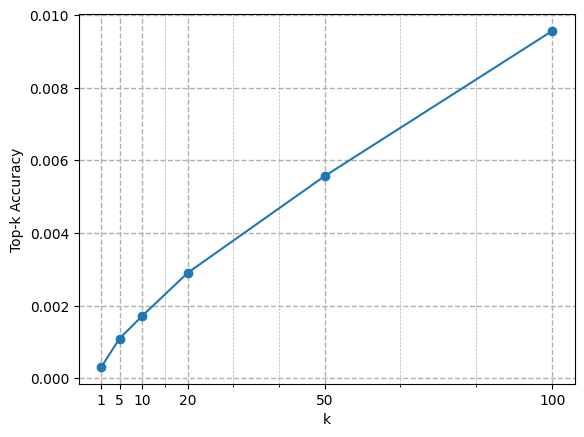

In [16]:
ks = [1, 5, 10, 20, 50, 100]

reference = list(range(0, fom_trans_matrix.size(0)))
topk_results = compute_topk_accuracy(fom_trans_matrix, reference, k=ks)

plt.plot(ks, topk_results, marker='o',)
plt.xlabel('k')
plt.ylabel('Top-k Accuracy')
# title
# plt.title(f"Top-k accuracy for LLaMA FOM / Self", fontsize=12)
plt.xticks(ks)
plt.gca().xaxis.set_minor_locator(FixedLocator([15, 30, 40, 66.67, 83.33]))
plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
# plt.savefig(f"Q2_{model_name}_FOM_topk_self.png") # Print as PNG
plt.savefig(f"Q2_{model_name}_FOM_topk_self.pdf") # Print as PDF 
plt.show()

## Experiment 2

We would also like to see how does the FOM compare with a 1-gram Markov model.
We train the Markov model on wikitext-2-raw-v1, using the original model's vocabulary and tokenization to extract n-grams to make the two models comparable.

As done previously, we recorded the average top-$(k_1, k_2)$ accuracy across all tokens inside the model's vocabulary, where $k_1$ refers to the $k$ hyperparameter for the FOM, and $k_2$ refers to the $k$ parameter for the Markov model.
Thus, for a single vocabulary term, we consider a match if the intersection of the top-$k_1$ predictions of the FOM and the top-$k_2$ predictions of the Markov model is not empty.

In [17]:
# https://nlp.cs.nyu.edu/wikipedia-data/
# wiki_2grams = "data/decoder_encoder/wp_2gram.txt"
# df = pd.read_csv(wiki_2grams, sep="\t", names=["Count", "Token1", "Token2"], quoting=csv.QUOTE_NONE)
# eos_token = "#EOS#"

# print(len(df.index))
# df.head(10)

In [18]:
# def remove_non_vocabulary_tokens(df, tokenizer, eos_token):
#     df = df[df["Count"] > 2]
#     print("Removed low count items -> ", len(df.index))

#     #if tokenizer.bos_token:
#     #    df.loc[:, ["Token1", "Token2"]] = df[["Token1", "Token2"]].astype(str).map(lambda x: x.replace(eos_token, tokenizer.bos_token))
#     #    print("Changed " + eos_token + " into " + tokenizer.bos_token)

#     df = df[df["Token1"].astype(str).apply(lambda row: len(tokenizer.tokenize(row)) == 1)]
#     print("Removed items with Token1 not in vocabulary -> ", len(df.index))

#     df = df[df["Token2"].astype(str).apply(lambda row: len(tokenizer.tokenize(row)) == 1)]
#     print("Removed items with Token2 not in vocabulary -> ", len(df.index))

#     df.loc[:, ["Token1", "Token2"]] = df[["Token1", "Token2"]].astype(str).map(lambda x: tokenizer.encode(x, add_special_tokens=False)[0])
#     print("Transformed text tokens in indexes")
#     return df

In [19]:
#df = remove_non_vocabulary_tokens(df, tokenizer, eos_token)

#df.head(10)

In [20]:
# Load wikietext dataset
wikitext = load_dataset("wikitext", "wikitext-2-raw-v1", split="train+test+validation")
wikitext

Dataset({
    features: ['text'],
    num_rows: 44836
})

In [21]:
# Compute tokens and frequencies from dataset
ngram_dict = defaultdict(lambda: 0, {})
frequency_dict = defaultdict(lambda: 0, {})
for txt in tqdm(wikitext):
    prev_token = -1
    for cur_token in tokenizer.encode(txt["text"]):
        frequency_dict[cur_token] += 1
        if prev_token != -1:
            ngram_dict[(prev_token, cur_token)] += 1
        prev_token = cur_token
frequency_sum = sum([ v for v in frequency_dict.values()])
frequency_dict = {k: v / frequency_sum for k,v in frequency_dict.items()}
frequency_list = [frequency_dict[i] if i in frequency_dict else 0 for i in range(0, len(tokenizer))]

print(f"Total of {frequency_sum} tokens")

100%|██████████| 44836/44836 [00:04<00:00, 9679.19it/s] 

Total of 3499853 tokens


In [22]:
# Transform raw token and frequency data to dataframe
data = [(k[0], k[1], v) for k, v in ngram_dict.items()]
df = pd.DataFrame(data, columns=["Token1", "Token2", "Count"])

df.head(10)

,Token1,Token2,Count
0,1,29871,28697
1,29871,353,7539
2,353,478,12
3,478,2235,62
4,2235,29891,66
5,29891,2849,58
6,2849,15336,36
7,15336,4027,47
8,4027,4786,15
9,4786,353,4


In [23]:
# Create the transition matrix for a 1-gram Markov model, given token/frequency dataframe
def build_transition_matrix(df, emb, smooth=0):
    emb_matrix = emb.weight.data
    n = emb_matrix.size(0)
    trans_matrix = torch.full((n, n), fill_value=smooth)
    for idx, row in df.iterrows():
        trans_matrix[row["Token1"], row["Token2"]] += row["Count"]
    # Normalize matrix
    trans_matrix = trans_matrix / trans_matrix.sum(dim=1, keepdim=True)
    trans_matrix[trans_matrix != trans_matrix] = 0 # Remove nans obtained by possible divisions by 0
    return trans_matrix

Distance between Markov matrix and identity matrix:

In [24]:
markov_trans_matrix = build_transition_matrix(df, fom_model["input"], smooth=1)
print(f"Distance from identity: {distance_from_I(markov_trans_matrix)}")

Distance from identity: 178.88124084472656


Distance between Markov matrix and FOM matrix:

In [25]:
matrix_distance(fom_trans_matrix, markov_trans_matrix)

tensor(504.9648)

In [26]:
# Most probable output 5 words according to FOM model, for each given input across its whole vocabulary
logits, topk = next_words(markov_trans_matrix, k=5)

Print most likely predictions according to Markov model for a set of test words:

In [27]:
# Encode the test words using the model's tokenizer
# (only take the first token if the word consists of multiple tokens)
word_tokens = [tokenizer.encode(word, add_special_tokens=False)[0] for word in words]

# Visualize likely output words
for word_token in word_tokens:
    print(vis_topk_result(tokenizer, topk, word_token))      

how -> to, the, it, he, much
mount -> s, ing, ings, ,, a
easy -> to, for, ., bru, going
hair -> ,, ., and, s, is
why -> he, the, it, they, his
If -> the, I, you, a, they
and -> the, , a, was, "
Good -> T, Things, man, win, things


Compute overall top-$k$ accuracy for the Markov matrix predicting:
- Itself ($k=1$)
- The vocabulary reference, therfore the identity function ($k=10$)

Compute overall top-$k$ accuracy for the FOM matrix predicting:
- The Markov matrix ($k_{Markov}=10$, $k_{FOM}=20$)

In [28]:
# Markov transition matrix should predict itself
_, reference = next_words(markov_trans_matrix, k=1)
print(compute_topk_accuracy(markov_trans_matrix, reference, k=1))

1.0


In [29]:
# Top-10 accuracy of the Markov transition matrix modeling the identity matrix, this is expected to be very low
reference = list(range(0, n_voc))
print(compute_topk_accuracy(markov_trans_matrix, reference, k=10))

0.0015625


In [30]:
# Top-(20, 10) accuracy of the FOM predicting the same as the Markov model
_, reference = next_words(markov_trans_matrix, k=10)
print(compute_topk_accuracy(fom_trans_matrix, reference, k=20))

0.1638125


Graph showcasing multiple values of $k_1$ and $k_2$ for the comparison between FOM and Markov model:

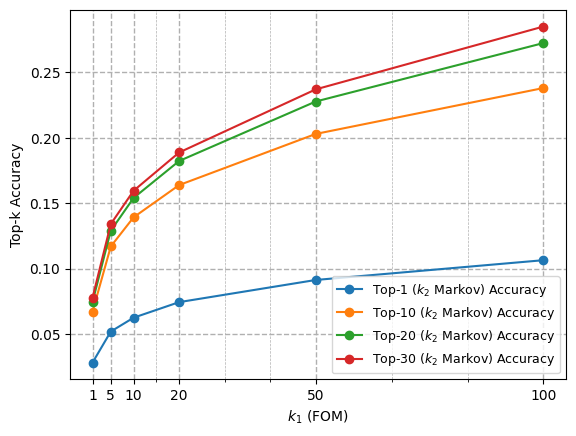

In [31]:
ks_markov = [1, 10, 20, 30]
ks_fom = [1, 5, 10, 20, 50, 100]

for k_markov in ks_markov:  

    _, reference = next_words(markov_trans_matrix, k=k_markov)
    topk_results = compute_topk_accuracy(fom_trans_matrix, reference, k=ks_fom)
    plt.plot(ks_fom, topk_results, marker='o', label=f'Top-{k_markov} ($k_2$ Markov) Accuracy')

plt.xlabel('$k_1$ (FOM)')
plt.ylabel('Top-k Accuracy')
# Title
# plt.title(f"Top-k accuracy for LLaMA FOM / Markov", fontsize=12)

# plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1)) # Print as PNG
plt.gca().xaxis.set_minor_locator(FixedLocator([15, 30, 40, 66.67, 83.33])) # Print as PDF
plt.gca().xaxis.set_major_locator(FixedLocator(ks_fom)) # Print as PDF

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
# plt.savefig(f"Q2_{model_name}_FOM_topk_Markov.png", bbox_inches='tight') # Print as PNG
plt.savefig(f"Q2_{model_name}_FOM_topk_Markov.pdf", bbox_inches='tight')
plt.show()

----

In [36]:
import gc
del ngram_dict
gc.collect()

NameError: name 'ngram_dict' is not defined

----

In [28]:
n_k = [1, 5, 10, 15, 25, 50, 100, 150, 250, 500, 750, 1000, 1500, 2000]
from numpy import random

In [29]:
def overlap_coef(set1, set2):
    return len(set1.intersection(set2)) / min((len(set1), len(set2)))

def jaccard_sim(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def sorensen_sim(set1, set2):
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))

In [30]:
_, fom_set = next_words(fom_trans_matrix, k=max(n_k))
_, markov_set = next_words(markov_trans_matrix, k=max(n_k))
random_set = [random.choice([i for i in range(0, n_voc)], size=max(n_k), replace=False) for j in range(0, n_voc)]

In [36]:
#_fom_set = [set(f) for f in fom_set]
#_markov_set = [set(m) for m in markov_set]
#_random_set = [set(r) for r in random_set]

#overlap = [overlap_coef(f, m) for f,m in zip(_fom_set, _markov_set)]
#overlap_rand_fom = [overlap_coef(f, r) for f,r in zip(_fom_set, _random_set)]
#overlap_rand_markov = [overlap_coef(m, r) for m,r in zip(_markov_set, _random_set)]

In [37]:
#print(f"Average overlap between FOM and Markov predictions: {sum(overlap) / len(overlap)}" )
#print(f"Average overlap between FOM and random predictions: {sum(overlap_rand_fom) / len(overlap_rand_fom)}")
#print(f"Average overlap between Markov and random predictions: {sum(overlap_rand_markov) / len(overlap_rand_markov)}")

In [31]:
def test_set_sim(set1, set2, baseline_set, n_k, sim_f):
    list_overlap = []
    list_overlap_b1 = []
    list_overlap_b2 = []
    for k in n_k:
        _set1 = [set(s[:k]) for s in set1]
        _set2 = [set(s[:k]) for s in set2]
        _baseline_set = [set(b[:k]) for b in baseline_set]

        overlap = [sim_f(s1, s2) for s1,s2 in zip(_set1, _set2)]
        overlap_b1 = [sim_f(s1, b) for s1,b in zip(_set1, _baseline_set)]
        overlap_b2 = [sim_f(s2, b) for s2,b in zip(_set2, _baseline_set)]

        list_overlap.append(sum(overlap) / len(overlap))
        list_overlap_b1.append(sum(overlap_b1) / len(overlap_b1))
        list_overlap_b2.append(sum(overlap_b2) / len(overlap_b2))

    return list_overlap, list_overlap_b1, list_overlap_b2

In [32]:
overlap, overlap_rf, overlap_rm = test_set_sim(fom_set, markov_set, random_set, n_k, overlap_coef)
jaccard, jaccard_rf, jaccard_rm = test_set_sim(fom_set, markov_set, random_set, n_k, jaccard_sim)
sorensen, sorensen_rf, sorensen_rm = test_set_sim(fom_set, markov_set, random_set, n_k, sorensen_sim)

The "jump" between 1 and 5 is due to the fact that most meaningful matching predictions for both models occur around the first 5 guesses.
After that the improvement follows the random one, implying that no meaningful prediction match is found that surclasses a random one

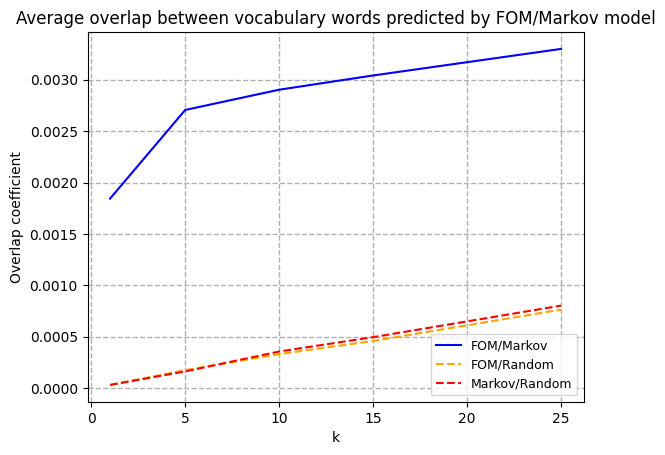

In [33]:
plt.plot(n_k[:5], overlap[:5], marker='', color="blue", label="FOM/Markov")
plt.plot(n_k[:5], overlap_rf[:5], marker='', color="orange", linestyle="--", label="FOM/Random")
plt.plot(n_k[:5], overlap_rm[:5], marker='',  color="red", linestyle="--", label="Markov/Random")

plt.title(f"Average overlap between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Overlap coefficient')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

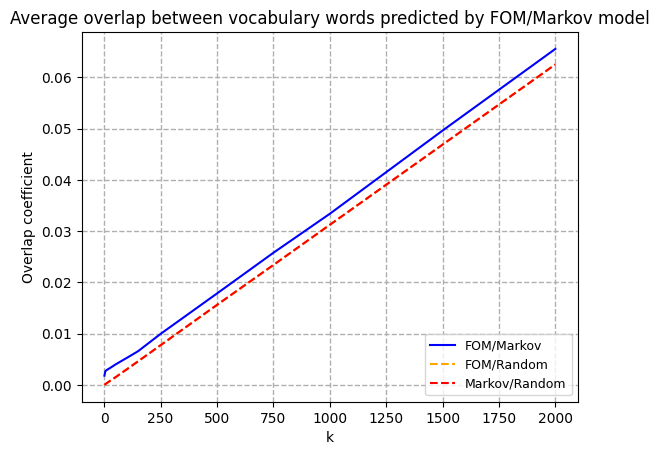

In [34]:
plt.plot(n_k, overlap, marker='', color="blue", label="FOM/Markov")
plt.plot(n_k, overlap_rf, marker='', color="orange", linestyle="--", label="FOM/Random")
plt.plot(n_k, overlap_rm, marker='',  color="red", linestyle="--", label="Markov/Random")

plt.title(f"Average overlap between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Overlap coefficient')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

The "inverse" jump may be explained from the fact that Jaccard similarity is inflated for sets with few elements

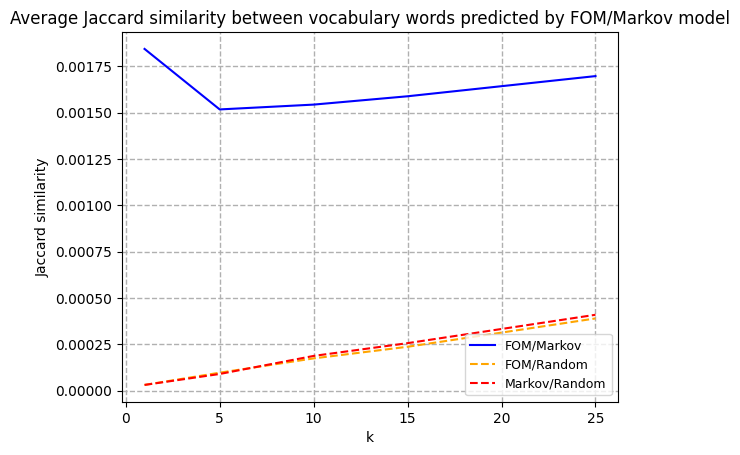

In [35]:
plt.plot(n_k[:5], jaccard[:5], marker='', color="blue", label="FOM/Markov")
plt.plot(n_k[:5], jaccard_rf[:5], marker='', color="orange", linestyle="--", label="FOM/Random")
plt.plot(n_k[:5], jaccard_rm[:5], marker='',  color="red", linestyle="--", label="Markov/Random")

plt.title(f"Average Jaccard similarity between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Jaccard similarity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

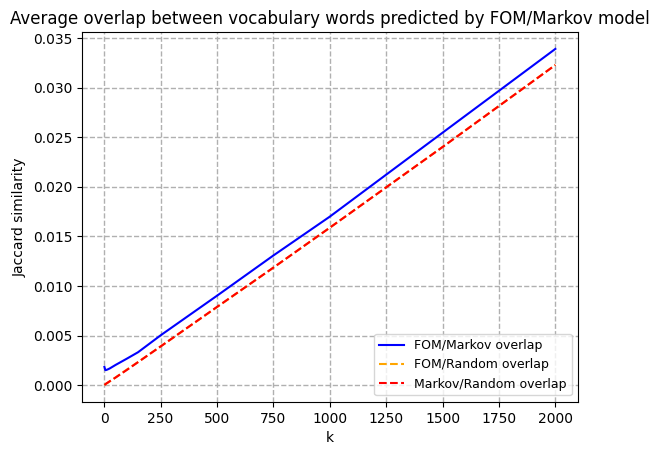

In [36]:
plt.plot(n_k, jaccard, marker='', color="blue", label="FOM/Markov overlap")
plt.plot(n_k, jaccard_rf, marker='', color="orange", linestyle="--", label="FOM/Random overlap")
plt.plot(n_k, jaccard_rm, marker='',  color="red", linestyle="--", label="Markov/Random overlap")

plt.title(f"Average overlap between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Jaccard similarity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

Sorensen is equal to the overlap index since $k$ is equal for both models, leading to equal-sized prediction sets

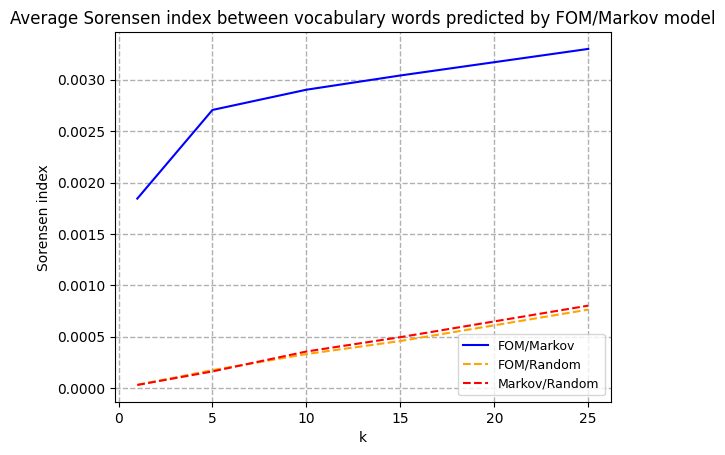

In [37]:
plt.plot(n_k[:5], sorensen[:5], marker='', color="blue", label="FOM/Markov")
plt.plot(n_k[:5], sorensen_rf[:5], marker='', color="orange", linestyle="--", label="FOM/Random")
plt.plot(n_k[:5], sorensen_rm[:5], marker='',  color="red", linestyle="--", label="Markov/Random")

plt.title(f"Average Sorensen index between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Sorensen index')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

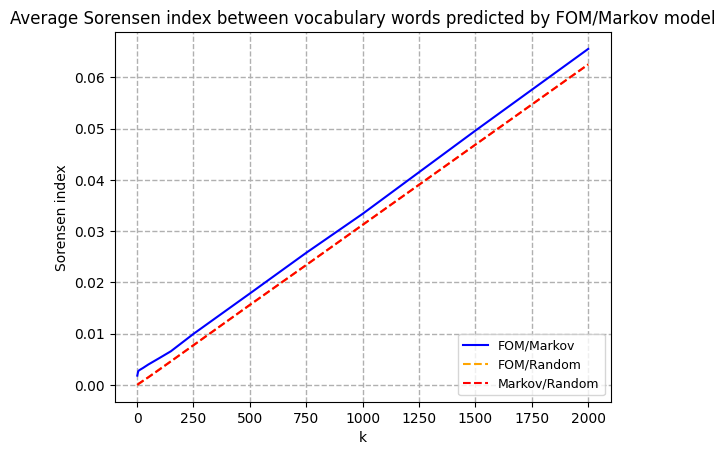

In [38]:
plt.plot(n_k, sorensen, marker='', color="blue", label="FOM/Markov")
plt.plot(n_k, sorensen_rf, marker='', color="orange", linestyle="--", label="FOM/Random")
plt.plot(n_k, sorensen_rm, marker='',  color="red", linestyle="--", label="Markov/Random")

plt.title(f"Average Sorensen index between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Sorensen index')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

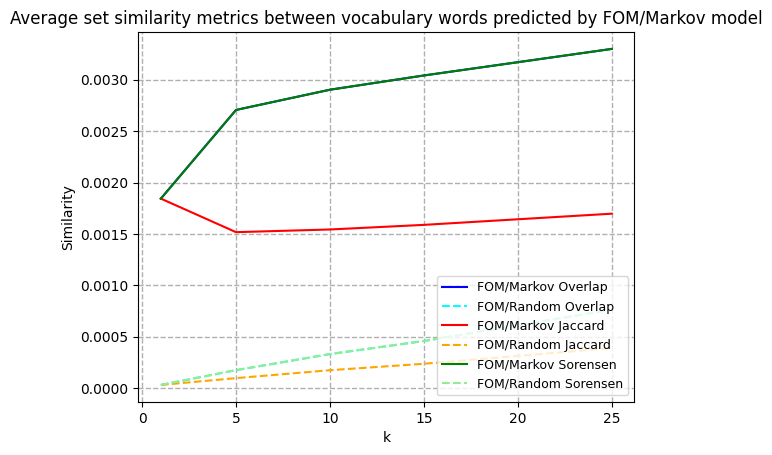

In [39]:
plt.plot(n_k[:5], overlap[:5], marker='', color="blue", label="FOM/Markov Overlap")
plt.plot(n_k[:5], overlap_rf[:5], marker='', color="cyan", linestyle="--", label="FOM/Random Overlap")

plt.plot(n_k[:5], jaccard[:5], marker='', color="red", label="FOM/Markov Jaccard")
plt.plot(n_k[:5], jaccard_rf[:5], marker='', color="orange", linestyle="--", label="FOM/Random Jaccard")

plt.plot(n_k[:5], sorensen[:5], marker='', color="green", label="FOM/Markov Sorensen")
plt.plot(n_k[:5], sorensen_rf[:5], marker='', color="lightgreen", linestyle="--", label="FOM/Random Sorensen")

plt.title(f"Average set similarity metrics between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Similarity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.savefig(f"Q2_{model_name}_sim5_FOM_Markov.png", bbox_inches='tight')
plt.show()

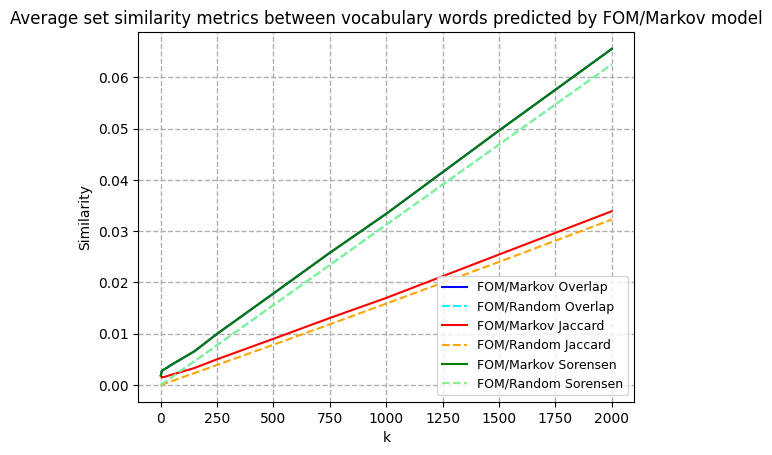

In [40]:
plt.plot(n_k, overlap, marker='', color="blue", label="FOM/Markov Overlap")
plt.plot(n_k, overlap_rf, marker='', color="cyan", linestyle="--", label="FOM/Random Overlap")

plt.plot(n_k, jaccard, marker='', color="red", label="FOM/Markov Jaccard")
plt.plot(n_k, jaccard_rf, marker='', color="orange", linestyle="--", label="FOM/Random Jaccard")

plt.plot(n_k, sorensen, marker='', color="green", label="FOM/Markov Sorensen")
plt.plot(n_k, sorensen_rf, marker='', color="lightgreen", linestyle="--", label="FOM/Random Sorensen")

plt.title(f"Average set similarity metrics between vocabulary words predicted by FOM/Markov model", fontsize=12)

plt.xlabel('k')
plt.ylabel('Similarity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
plt.legend(loc="lower right", prop={'size': 9})
plt.savefig(f"Q2_{model_name}_simall_FOM_Markov.png", bbox_inches='tight')
plt.show()

----

In [32]:
import gc
del fom_set, markov_set, random_set
del overlap, overlap_rf, overlap_rm
del jaccard, jaccard_rf, jaccard_rm
del sorensen, sorensen_rf, sorensen_rm
gc.collect()

4433

In [48]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

----

In [32]:
from torcheval.metrics.functional.text import perplexity

def compute_perplexity(dataset, tokenizer, predict):
    perp = []
    for txt in tqdm(dataset):
        perp_logits = []
        perp_truths = []
        prev_token = -1
        if len(tokenizer.encode(txt["text"])) > 1:
            for cur_token in tokenizer.encode(txt["text"]):
                if prev_token != -1:
                    logits = predict(prev_token)
                    perp_logits.append(logits)
                    perp_truths.append(cur_token)
                prev_token = cur_token
            perp.append(perplexity(torch.stack(perp_logits).unsqueeze(0), torch.IntTensor(perp_truths).unsqueeze(0)))
    return torch.stack(perp)

In [33]:
perp_markov = compute_perplexity(wikitext, tokenizer, lambda tok: markov_trans_matrix[tok, :])
perp_fom = compute_perplexity(wikitext, tokenizer, lambda tok: fom_trans_matrix[tok, :])
perp_random = compute_perplexity(wikitext, tokenizer, lambda tok: torch.FloatTensor(n_voc).uniform_(-1, 1))

100%|██████████| 44836/44836 [05:16<00:00, 141.48it/s]


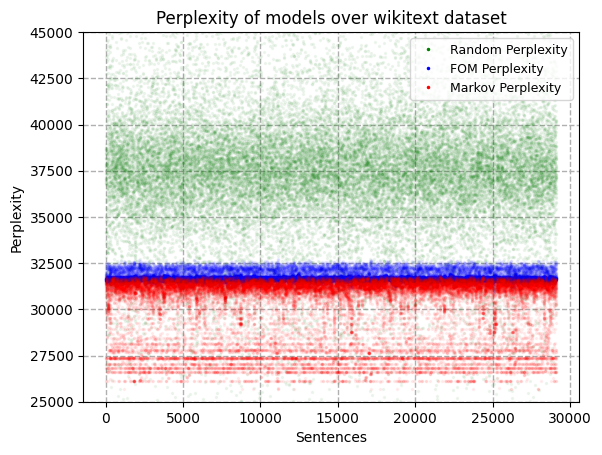

In [34]:
perp_n = list(range(0, len(perp_random)))

plt.plot(perp_n, perp_random, marker='.', color="green", linestyle="", alpha=0.05, markersize=3, label="Random Perplexity")
plt.plot(perp_n, perp_fom, marker='.', color="blue", linestyle="", alpha=0.05, markersize=3, label="FOM Perplexity")
plt.plot(perp_n, perp_markov, marker='.', color="red", linestyle="", alpha=0.05, markersize=3, label="Markov Perplexity")


plt.title(f"Perplexity of models over wikitext dataset", fontsize=12)

plt.xlabel('Sentences')
plt.ylabel('Perplexity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
legend = plt.legend(prop={'size': 9})
# Avoid transparency in legend
for lh in legend.legend_handles: 
    lh.set_alpha(1)
plt.ylim(25000, 45000)
plt.savefig(f"Q2_{model_name}_perplexity.png", bbox_inches='tight')
plt.show()

----

In [36]:
import gc
del perp_markov, perp_fom, perp_random
gc.collect()

35

----

In [37]:
ids = range(0, n_voc)

In [38]:
def normalize_logits(logits):
    min_val = torch.min(logits, dim=-1).values.unsqueeze(-1).expand(-1, logits.size(-1))
    max_val = torch.max(logits, dim=-1).values.unsqueeze(-1).expand(-1, logits.size(-1))
    normalized_logits = torch.div((logits - min_val), (max_val - min_val))
    normalized_logits = torch.nan_to_num(normalized_logits, 0.5)
    return normalized_logits

from scipy.special import rel_entr

In [39]:
fom_logits, _ = next_words(fom_trans_matrix, k=1)
markov_logits, _ = next_words(markov_trans_matrix, k=1)

fom_logits = normalize_logits(torch.stack(fom_logits))
markov_logits = normalize_logits(torch.stack(markov_logits))

fom_probs = torch.nn.functional.softmax(fom_logits, dim=-1)
markov_probs = torch.nn.functional.softmax(markov_logits, dim=-1)

In [54]:
# kl_div = torch.nn.functional.kl_div(fom_probs, markov_probs, reduction="batchmean")
# scipy.special.rel_entr(fom_probs, markov_probs).sum(dim=-1)
# kl_div = scipy.special.kl_div(fom_probs, markov_probs).sum(dim=-1)
kl_div = scipy.special.kl_div(markov_probs, fom_probs).sum(dim=-1)

# base_fom_kl_div = torch.stack([
#     scipy.special.kl_div(torch.full_like(fom_prob, 1 / len(fom_prob)), fom_prob).sum()
#     for fom_prob in fom_probs
# ])
base_fom_kl_div = torch.stack([
    scipy.special.kl_div(fom_prob, torch.full_like(fom_prob, 1 / len(fom_prob))).sum()
    for fom_prob in fom_probs
])

# base_markov_kl_div = torch.stack([
#     scipy.special.kl_div(torch.full_like(markov_prob, 1 / len(markov_prob)), markov_prob).sum()
#     for markov_prob in markov_probs
# ])
base_markov_kl_div = torch.stack([
    scipy.special.kl_div(markov_prob, torch.full_like(markov_prob, 1 / len(markov_prob))).sum()
    for markov_prob in markov_probs
])

In [55]:
avg_kl = torch.mean(kl_div)
weighted_avg_kl = torch.mean(torch.stack([kl_div[i] * w for i, w in frequency_dict.items()]))

weighted_avg_fom_kl = torch.mean(torch.stack([base_fom_kl_div[i] * w for i, w in frequency_dict.items()]))
weighted_avg_markov_kl = torch.mean(torch.stack([base_markov_kl_div[i] * w for i, w in frequency_dict.items()]))

print(f"Average Kullback-Leibler divergence across all {len(kl_div)} tokens: {avg_kl}")
print(f"Average weighted Kullback-Leibler divergence across all {len(kl_div)} tokens: {weighted_avg_kl}")
print(f"Average weighted Kullback-Leibler divergence between Uniform and FOM across all {len(kl_div)} tokens : {weighted_avg_fom_kl}")
print(f"Average weighted Kullback-Leibler divergence between Uniform and Markov across all {len(kl_div)} tokens: {weighted_avg_markov_kl}")


Average Kullback-Leibler divergence across all 32000 tokens: 0.0060200802981853485
Average weighted Kullback-Leibler divergence across all 32000 tokens: 2.793383089283452e-07
Average weighted Kullback-Leibler divergence between Uniform and FOM across all 32000 tokens : 2.773274445644347e-07
Average weighted Kullback-Leibler divergence between Uniform and Markov across all 32000 tokens: 3.215656629862451e-09


In [56]:
pairs = list(zip(kl_div, base_fom_kl_div))

pairs.sort(key=lambda p: (p[0], p[1]))
sorted_kl1, sorted_kl2 = zip(*pairs)

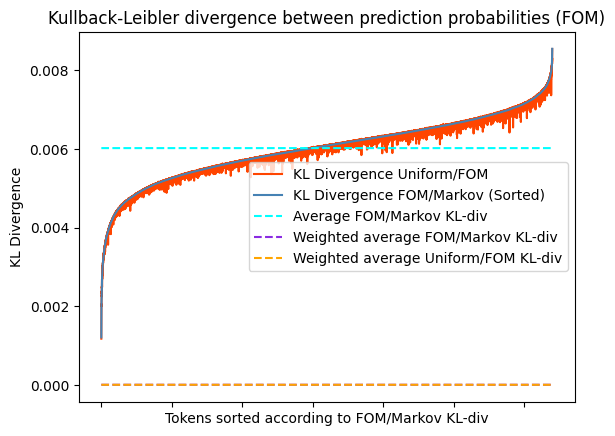

In [57]:
plt.plot(ids, sorted_kl2, color="orangered", label=f'KL Divergence Uniform/FOM')
plt.plot(ids, sorted_kl1, color="steelblue", label=f'KL Divergence FOM/Markov (Sorted)')
plt.plot(ids, [avg_kl] * len(ids), color="cyan", linestyle = '--', label=f'Average FOM/Markov KL-div')
plt.plot(ids, [weighted_avg_kl] * len(ids), color="blueviolet", linestyle = '--', label=f'Weighted average FOM/Markov KL-div')
plt.plot(ids, [weighted_avg_fom_kl] * len(ids), color="orange", linestyle = '--', label=f'Weighted average Uniform/FOM KL-div')

plt.xlabel('Tokens sorted according to FOM/Markov KL-div')
plt.ylabel('KL Divergence')
plt.title(f"Kullback-Leibler divergence between prediction probabilities (FOM)", fontsize=12)
plt.legend()
plt.savefig(f"Q2_{model_name}_KLdiv_a_markov_fom.png", bbox_inches='tight')
plt.xticks(visible=False)
plt.show()

In [44]:
pairs = list(zip(kl_div, base_markov_kl_div))

pairs.sort(key=lambda p: (p[0], p[1]))
sorted_kl1, sorted_kl2 = zip(*pairs)

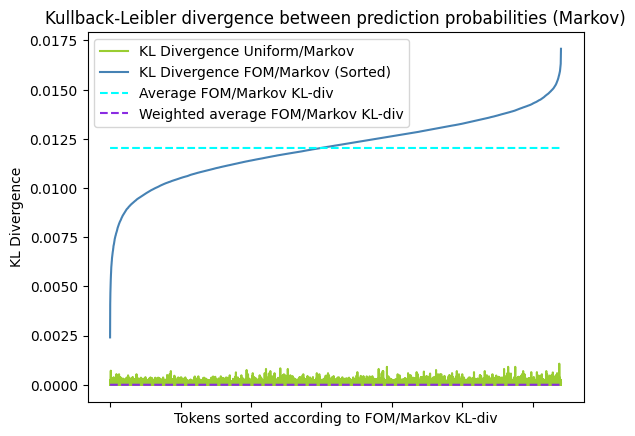

In [45]:
plt.plot(ids, sorted_kl2, color="yellowgreen", label=f'KL Divergence Uniform/Markov')
plt.plot(ids, sorted_kl1, color="steelblue", label=f'KL Divergence FOM/Markov (Sorted)')
plt.plot(ids, [avg_kl] * len(ids), color="cyan", linestyle = '--', label=f'Average FOM/Markov KL-div')
plt.plot(ids, [weighted_avg_kl] * len(ids), color="blueviolet", linestyle = '--', label=f'Weighted average FOM/Markov KL-div')

plt.xlabel('Tokens sorted according to FOM/Markov KL-div')
plt.ylabel('KL Divergence')
plt.title(f"Kullback-Leibler divergence between prediction probabilities (Markov)", fontsize=12)
plt.legend()
plt.savefig(f"Q2_{model_name}_KLdiv_b.png", bbox_inches='tight')
plt.xticks(visible=False)
plt.show()

In [46]:
pairs = list(zip(base_fom_kl_div, base_markov_kl_div))

pairs.sort(key=lambda p: (p[1], p[0]))
sorted_kl1, sorted_kl2 = zip(*pairs)

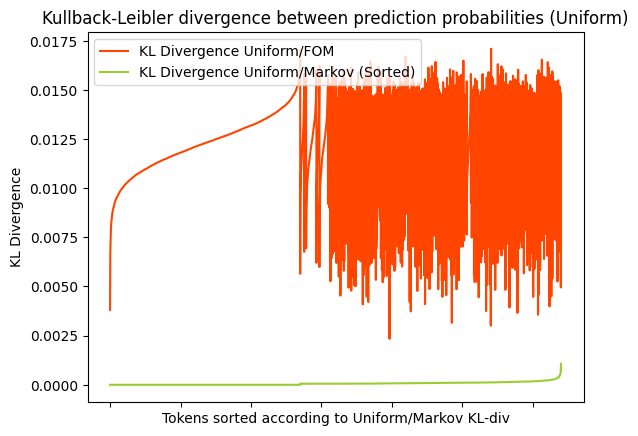

In [47]:
plt.plot(ids, sorted_kl1, color="orangered", label=f'KL Divergence Uniform/FOM')
plt.plot(ids, sorted_kl2, color="yellowgreen", label=f'KL Divergence Uniform/Markov (Sorted)')

plt.xlabel('Tokens sorted according to Uniform/Markov KL-div')
plt.ylabel('KL Divergence')
plt.title(f"Kullback-Leibler divergence between prediction probabilities (Uniform)", fontsize=12)
plt.legend()
plt.savefig(f"Q2_{model_name}_KLdiv_c.png", bbox_inches='tight')
plt.xticks(visible=False)
plt.show()

----

In [146]:
n_top = 10000
top_elements = sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True)[:n_top]
top_ids = [i for i,w in top_elements]
top_weights = [w for i,w in top_elements]
uniform_prob = 1 / 32000

In [160]:
1 / 32000

3.125e-05

In [66]:
# fom_logits, _ = next_words(fom_trans_matrix, k=1)
# markov_logits, _ = next_words(markov_trans_matrix, k=1)

# fom_logits = normalize_logits(torch.stack(fom_logits))
# markov_logits = normalize_logits(torch.stack(markov_logits))

# #fom_logits = torch.topk(fom_logits, n_cut, dim=-1).values
# #markov_logits = torch.topk(markov_logits, n_cut, dim=-1).values

# fom_probs = torch.nn.functional.softmax(fom_logits, dim=-1)
# markov_probs = torch.nn.functional.softmax(markov_logits, dim=-1)

# fom_probs = torch.nn.functional.threshold(fom_probs, uniform_prob, 0)
# markov_probs = torch.nn.functional.threshold(markov_probs, uniform_prob, 0)

# fom_probs = fom_probs / fom_probs.sum(dim=-1).unsqueeze(-1)
# markov_probs = markov_probs / markov_probs.sum(dim=-1).unsqueeze(-1)

# #fom_probs = torch.nan_to_num(fom_probs, uniform_prob)
# #markov_probs = torch.nan_to_num(markov_probs, uniform_prob)

In [67]:
#fom_logits, _ = next_words(fom_trans_matrix, k=1)
#markov_logits, _ = next_words(markov_trans_matrix, k=1)

# fom_logits = normalize_logits(torch.stack(fom_logits))
# markov_logits = normalize_logits(torch.stack(markov_logits))

# fom_soft_probs = torch.nn.functional.softmax(fom_logits, dim=-1)
# markov_soft_probs = torch.nn.functional.softmax(markov_logits, dim=-1)

# fom_probs = fom_logits / fom_logits.sum(dim=-1).unsqueeze(-1)
# markov_probs = markov_logits / markov_logits.sum(dim=-1).unsqueeze(-1)

In [147]:
fom_logits, _ = next_words(fom_trans_matrix, k=1)
markov_logits, _ = next_words(markov_trans_matrix, k=1)

fom_logits = normalize_logits(torch.stack(fom_logits))
markov_logits = normalize_logits(torch.stack(markov_logits))

fom_logits = fom_logits[top_ids]
markov_logits = markov_logits[top_ids]

fom_probs = torch.nn.functional.softmax(fom_logits, dim=-1)
markov_probs = torch.nn.functional.softmax(markov_logits, dim=-1)

In [151]:
torch.stack([
    scipy.special.kl_div(torch.full_like(fom_prob, 1 / len(fom_prob)), fom_prob).sum()
    for fom_prob in fom_probs
])

tensor([0.0055, 0.0053, 0.0044,  ..., 0.0064, 0.0075, 0.0064])

In [152]:
torch.stack([
    scipy.special.kl_div(fom_prob, torch.full_like(fom_prob, 1 / len(fom_prob))).sum()
    for fom_prob in fom_probs
])

tensor([0.0055, 0.0053, 0.0044,  ..., 0.0065, 0.0075, 0.0064])

In [153]:
scipy.special.kl_div(fom_probs, markov_probs).sum(dim=-1)

tensor([0.0055, 0.0054, 0.0044,  ..., 0.0065, 0.0075, 0.0064])

In [154]:
scipy.special.kl_div(markov_probs, fom_probs).sum(dim=-1)

tensor([0.0055, 0.0054, 0.0044,  ..., 0.0065, 0.0075, 0.0064])

In [165]:
fom_probs[0].topk(10)

torch.return_types.topk(
values=tensor([5.4392e-05, 5.2542e-05, 5.0019e-05, 4.8794e-05, 4.7348e-05, 4.7201e-05,
        4.7068e-05, 4.6841e-05, 4.6560e-05, 4.6388e-05]),
indices=tensor([ 1348,  6065, 24660,  4695,  7450,  5977, 25751,  1432,   948,  1489]))

In [164]:
markov_probs[0].topk(10)

torch.return_types.topk(
values=tensor([8.4873e-05, 4.6816e-05, 3.8025e-05, 3.7508e-05, 3.7390e-05, 3.6855e-05,
        3.6794e-05, 3.6712e-05, 3.5814e-05, 3.5636e-05]),
indices=tensor([28705,   907,  2969,  1348,   345,  2990,  2039,  4034,   948,  1080]))

In [148]:
# kl_div = scipy.special.kl_div(fom_probs, markov_probs).sum(dim=-1)
kl_div = scipy.special.kl_div(fom_probs, markov_probs).sum(dim=-1)
kl_div += scipy.special.kl_div(markov_probs, fom_probs).sum(dim=-1)

base_fom_kl_div = torch.stack([
    scipy.special.kl_div(torch.full_like(fom_prob, 1 / len(fom_prob)), fom_prob).sum()
    for fom_prob in fom_probs
])
base_fom_kl_div += torch.stack([
    scipy.special.kl_div(fom_prob, torch.full_like(fom_prob, 1 / len(fom_prob))).sum()
    for fom_prob in fom_probs
])

base_markov_kl_div = torch.stack([
    scipy.special.kl_div(torch.full_like(markov_prob, 1 / len(markov_prob)), markov_prob).sum()
    for markov_prob in markov_probs
])
base_markov_kl_div += torch.stack([
    scipy.special.kl_div(markov_prob, torch.full_like(markov_prob, 1 / len(markov_prob))).sum()
    for markov_prob in markov_probs
])

In [112]:
avg_kl = torch.mean(kl_div)
weighted_avg_kl = torch.mean(torch.stack([kl_div[i] * w for i, w in frequency_dict.items()]))

weighted_avg_fom_kl = torch.mean(torch.stack([base_fom_kl_div[i] * w for i, w in frequency_dict.items()]))
weighted_avg_markov_kl = torch.mean(torch.stack([base_markov_kl_div[i] * w for i, w in frequency_dict.items()]))

print(f"Average Kullback-Leibler divergence across all {len(kl_div)} tokens: {avg_kl}")
print(f"Average weighted Kullback-Leibler divergence across all {len(kl_div)} tokens: {weighted_avg_kl}")
print(f"Average weighted Kullback-Leibler divergence between Uniform and FOM across all {len(kl_div)} tokens : {weighted_avg_fom_kl}")
print(f"Average weighted Kullback-Leibler divergence between Uniform and Markov across all {len(kl_div)} tokens: {weighted_avg_markov_kl}")


IndexError: index 28705 is out of bounds for dimension 0 with size 10

In [149]:
pairs = list(zip(top_weights, kl_div, base_fom_kl_div))

pairs.sort(key=lambda p: (p[0], p[1], p[2]))
_, sorted_kl1, sorted_kl2 = zip(*pairs)

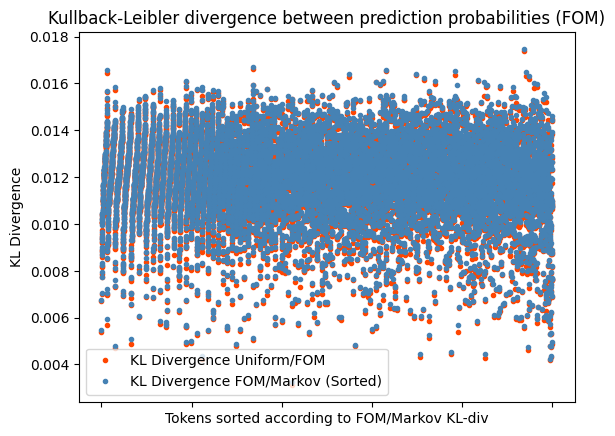

In [150]:
plt.plot(range(0,len(top_ids)), sorted_kl2, color="orangered", marker='.', linestyle="", alpha=1, label=f'KL Divergence Uniform/FOM')
plt.plot(range(0,len(top_ids)), sorted_kl1, color="steelblue", marker='.', linestyle="", alpha=1, label=f'KL Divergence FOM/Markov (Sorted)')
#plt.plot(ids, [avg_kl] * len(ids), color="cyan", linestyle = '--', label=f'Average FOM/Markov KL-div')
#plt.plot(ids, [weighted_avg_kl] * len(ids), color="blueviolet", linestyle = '--', label=f'Weighted average FOM/Markov KL-div')
#plt.plot(ids, [weighted_avg_fom_kl] * len(ids), color="orange", linestyle = '--', label=f'Weighted average Uniform/FOM KL-div')

plt.xlabel('Tokens sorted according to FOM/Markov KL-div')
plt.ylabel('KL Divergence')
plt.title(f"Kullback-Leibler divergence between prediction probabilities (FOM)", fontsize=12)
plt.legend()
#plt.savefig(f"Q2_{model_name}_KLdiv_a.png", bbox_inches='tight')
plt.xticks(visible=False)
plt.show()

In [140]:
pairs = list(zip(kl_div, base_markov_kl_div))

pairs.sort(key=lambda p: (p[0], p[1]))
sorted_kl1, sorted_kl2 = zip(*pairs)

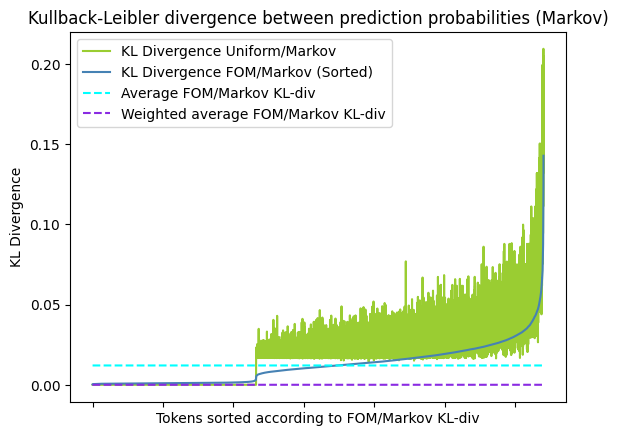

In [50]:
plt.plot(ids, sorted_kl2, color="yellowgreen", label=f'KL Divergence Uniform/Markov')
plt.plot(ids, sorted_kl1, color="steelblue", label=f'KL Divergence FOM/Markov (Sorted)')
plt.plot(ids, [avg_kl] * len(ids), color="cyan", linestyle = '--', label=f'Average FOM/Markov KL-div')
plt.plot(ids, [weighted_avg_kl] * len(ids), color="blueviolet", linestyle = '--', label=f'Weighted average FOM/Markov KL-div')

plt.xlabel('Tokens sorted according to FOM/Markov KL-div')
plt.ylabel('KL Divergence')
plt.title(f"Kullback-Leibler divergence between prediction probabilities (Markov)", fontsize=12)
plt.legend()
#plt.savefig(f"Q2_{model_name}_KLdiv_b.png", bbox_inches='tight')
plt.xticks(visible=False)
plt.show()

----

In [59]:
cos_fom_markov = torch.nn.functional.cosine_similarity(markov_trans_matrix, fom_trans_matrix, dim=-1)
cos_fom_random = torch.nn.functional.cosine_similarity(fom_trans_matrix, torch.full_like(fom_trans_matrix, 0.5), dim=-1)
#cos_markov_random = torch.nn.functional.cosine_similarity(markov_trans_matrix, torch.full_like(markov_trans_matrix, fill_value=0.5), dim=-1)

In [60]:
wavg_cos_fom_markov = torch.mean(torch.stack([cos_fom_markov[i] * w for i, w in frequency_dict.items()]))
wavg_cos_fom_random = torch.mean(torch.stack([cos_fom_random[i] * w for i, w in frequency_dict.items()]))

print(f"Average weighted cosine similarity between FOM and Markov across all {n_voc} tokens: {wavg_cos_fom_markov}")
print(f"Average weighted cosine similarity between FOM and Uniform across all {n_voc} tokens: {wavg_cos_fom_random}")

Average weighted cosine similarity between FOM and Markov across all 32000 tokens: 2.30183094807046e-09
Average weighted cosine similarity between FOM and Uniform across all 32000 tokens: -1.5993197166608297e-06


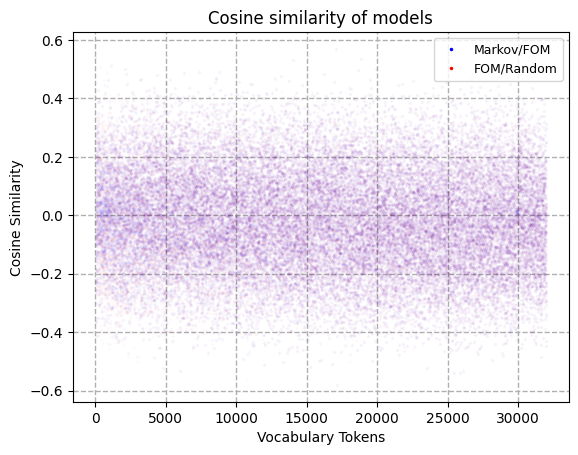

In [63]:
cos_n = list(range(0, len(cos_fom_markov)))

plt.plot(cos_n, cos_fom_markov, marker='.', color="blue", linestyle="", alpha=0.02, markersize=3, label="Markov/FOM")
plt.plot(cos_n, cos_fom_random, marker='.', color="red", linestyle="", alpha=0.01, markersize=3, label="FOM/Random")


plt.title(f"Cosine similarity of models", fontsize=12)

plt.xlabel('Vocabulary Tokens')
plt.ylabel('Cosine Similarity')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))

plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
plt.grid(linestyle = '--', linewidth = 1, which="major")
legend = plt.legend(prop={'size': 9})
# Avoid transparency in legend
for lh in legend.legend_handles: 
    lh.set_alpha(1)
plt.savefig(f"Q2_{model_name}_cosine.png", bbox_inches='tight')
plt.show()